<a href="https://colab.research.google.com/github/Exsi4r/IR-Project-Group-kelompok-3-tki/blob/main/Tugas_kelompok_3_tki_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import library & load data

In [1]:
# ==============================
# 1. Import library & load data
# ==============================
import pandas as pd
import numpy as np
import re
import math
from collections import defaultdict, Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

!pip install nltk --quiet
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Load dataset
df = pd.read_csv("Clean_IR_Dataset_300_Documents.csv")
df.columns = [c.strip().lower() for c in df.columns]  # id, category, text
df["text"] = df["text"].astype(str)

print("Shape:", df.shape)
print(df.head())
print("\nJumlah dokumen per kategori:")
print(df["category"].value_counts())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Shape: (300, 3)
   id       category                                               text
0   1      sci.space  A newly designed lunar rover is being tested f...
1   2      rec.autos  New braking systems reduce stopping distance s...
2   3      rec.autos  Motorcycle sales increase following new effici...
3   4  comp.graphics  Open‑source graphics libraries introduce new r...
4   5      sci.space  A rare solar flare disrupted communication sat...

Jumlah dokumen per kategori:
category
comp.graphics    102
sci.space         99
rec.autos         99
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2. Preprocessing, vocabulary, inverted index

In [3]:
# ==============================
# 2. Preprocessing & struktur IR
# ==============================
nltk.download('punkt_tab') # Added to resolve LookupError

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)               # hapus HTML
    text = re.sub(r"[^a-zA-Z]", " ", text)          # hanya huruf
    text = text.lower()
    return text

def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(t) for t in tokens
              if t not in stop_words and len(t) > 2]
    return tokens

# Terapkan ke semua dokumen
df["tokens"] = df["text"].apply(preprocess)

# Vocabulary
vocab = sorted({t for toks in df["tokens"] for t in toks})
term_to_id = {t: i for i, t in enumerate(vocab)}
print("Jumlah dokumen:", len(df))
print("Ukuran vocabulary:", len(vocab))

# Inverted index: term -> list (doc_id, tf)
inverted_index = defaultdict(list)
for _, row in df.iterrows():
    doc_id = int(row["id"])
    counts = Counter(row["tokens"])
    for term, tf in counts.items():
        inverted_index[term].append((doc_id, tf))

print("\nContoh posting list untuk term 'space' (jika ada):")
print(inverted_index.get("space", [])[:10])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Jumlah dokumen: 300
Ukuran vocabulary: 182

Contoh posting list untuk term 'space' (jika ada):
[(9, 1), (12, 1), (29, 1), (37, 1), (39, 1), (58, 1), (63, 1), (66, 1), (75, 1), (82, 1)]


3. Model 1: TF‑IDF (VSM)

In [4]:
# ==============================
# 3. TF-IDF Vector Space Model
# ==============================

df["clean_str"] = df["tokens"].apply(lambda toks: " ".join(toks))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_str"])  # (n_docs, n_terms)

def tfidf_search(query, top_k=20):
    q_tokens = preprocess(query)
    q_str = " ".join(q_tokens)
    q_vec = tfidf_vectorizer.transform([q_str])
    scores = cosine_similarity(q_vec, tfidf_matrix)[0]
    ranked_idx = np.argsort(scores)[::-1]
    results = []
    for idx in ranked_idx[:top_k]:
        results.append((int(df.iloc[idx]["id"]), float(scores[idx])))
    return results

# Cek cepat
print("Contoh hasil TF-IDF:", tfidf_search("electric vehicle battery", top_k=5))


Contoh hasil TF-IDF: [(48, 0.5742022309536406), (260, 0.5742022309536406), (30, 0.5742022309536406), (34, 0.5742022309536406), (156, 0.5742022309536406)]


4. Model 2: BM25

In [5]:
# ==============================
# 4. BM25
# ==============================

k1 = 1.5
b = 0.75

N = len(df)
doc_lengths = {}
term_doc_freq = defaultdict(int)

for _, row in df.iterrows():
    doc_id = int(row["id"])
    tokens = row["tokens"]
    doc_lengths[doc_id] = len(tokens)
    for t in set(tokens):
        term_doc_freq[t] += 1

avgdl = np.mean(list(doc_lengths.values()))

def bm25_idf(term):
    df_t = term_doc_freq.get(term, 0)
    if df_t == 0:
        return 0.0
    return math.log((N - df_t + 0.5) / (df_t + 0.5) + 1)

def bm25_search(query, top_k=20):
    q_tokens = preprocess(query)
    scores = defaultdict(float)
    for term in q_tokens:
        postings = inverted_index.get(term, [])
        idf_t = bm25_idf(term)
        for doc_id, tf in postings:
            dl = doc_lengths[doc_id]
            denom = tf + k1 * (1 - b + b * dl / avgdl)
            score = idf_t * (tf * (k1 + 1)) / denom
            scores[doc_id] += score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return ranked

print("Contoh hasil BM25:", bm25_search("electric vehicle battery", top_k=5))


Contoh hasil BM25: [(30, np.float64(8.21151899520817)), (34, np.float64(8.21151899520817)), (48, np.float64(8.21151899520817)), (153, np.float64(8.21151899520817)), (156, np.float64(8.21151899520817))]


5. Query + ground truth (isi manual, contoh disediakan)

In [6]:
# ==============================
# 5. Query & Ground Truth
# ==============================

queries = {
    "Q1": "electric vehicle battery",
    "Q2": "rocket launch space mission",
    "Q3": "gpu rendering graphics",
    "Q4": "autonomous driving system",
    "Q5": "lunar rover moon mission",
    "Q6": "cosmic radiation space travel",
    "Q7": "hybrid cars fuel consumption",
    "Q8": "real time ray tracing",
    "Q9": "satellite atmospheric changes",
    "Q10": "motorcycle safety upgrades"
}

# TODO: GANTI ID berikut dengan hasil penilaian manual kamu
ground_truth = {
    "Q1":  [260, 273, 293, 296, 285],   # contoh
    "Q2":  [252, 261, 276, 281, 289],
    "Q3":  [264, 268, 270, 286, 290],
    "Q4":  [278, 299, 285, 277, 291],
    "Q5":  [283, 297, 287, 279, 294],
    "Q6":  [254, 279, 271, 294, 261],
    "Q7":  [256, 262, 285, 296, 299],
    "Q8":  [270, 280, 286, 295, 290],
    "Q9":  [271, 284, 263, 294, 261],
    "Q10": [274, 292, 291, 277, 285]
}


6. Fungsi evaluasi: P@k, R@k, F1, AP, MAP

In [7]:
# ==============================
# 6. Evaluasi: P@k, R@k, F1, AP, MAP
# ==============================

def precision_at_k(ranked_docs, rel_docs, k):
    ranked_k = [d for d, _ in ranked_docs[:k]]
    if k == 0:
        return 0.0
    hits = sum(1 for d in ranked_k if d in rel_docs)
    return hits / k

def recall_at_k(ranked_docs, rel_docs, k):
    ranked_k = [d for d, _ in ranked_docs[:k]]
    if len(rel_docs) == 0:
        return 0.0
    hits = sum(1 for d in ranked_k if d in rel_docs)
    return hits / len(rel_docs)

def f1_at_k(p, r):
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def average_precision(ranked_docs, rel_docs):
    hits = 0
    sum_prec = 0.0
    for i, (doc_id, _) in enumerate(ranked_docs, start=1):
        if doc_id in rel_docs:
            hits += 1
            sum_prec += hits / i
    if hits == 0:
        return 0.0
    return sum_prec / hits

def evaluate_model(search_func, queries, ground_truth, ks=[5, 10, 20]):
    results = {}
    ap_list = []
    for qid, qtext in queries.items():
        rel_docs = set(ground_truth[qid])
        ranked = search_func(qtext, top_k=max(ks))
        metrics_q = {}
        for k in ks:
            p = precision_at_k(ranked, rel_docs, k)
            r = recall_at_k(ranked, rel_docs, k)
            f1 = f1_at_k(p, r)
            metrics_q[f"P@{k}"] = p
            metrics_q[f"R@{k}"] = r
            metrics_q[f"F1@{k}"] = f1
        ap = average_precision(ranked, rel_docs)
        metrics_q["AP"] = ap
        ap_list.append(ap)
        results[qid] = metrics_q
    MAP = float(np.mean(ap_list)) if ap_list else 0.0
    return results, MAP


7. Jalankan evaluasi TF‑IDF & BM25

In [8]:
# ==============================
# 7. Jalankan evaluasi
# ==============================

ks = [5, 10, 20]

tfidf_results, tfidf_MAP = evaluate_model(tfidf_search, queries, ground_truth, ks=ks)
bm25_results, bm25_MAP = evaluate_model(bm25_search, queries, ground_truth, ks=ks)

print("=== TF-IDF ===")
for qid, m in tfidf_results.items():
    print(qid, m)
print("MAP TF-IDF:", tfidf_MAP)

print("\n=== BM25 ===")
for qid, m in bm25_results.items():
    print(qid, m)
print("MAP BM25:", bm25_MAP)


=== TF-IDF ===
Q1 {'P@5': 0.2, 'R@5': 0.2, 'F1@5': 0.20000000000000004, 'P@10': 0.1, 'R@10': 0.2, 'F1@10': 0.13333333333333333, 'P@20': 0.15, 'R@20': 0.6, 'F1@20': 0.24, 'AP': 0.3106060606060606}
Q2 {'P@5': 0.6, 'R@5': 0.6, 'F1@5': 0.6, 'P@10': 0.3, 'R@10': 0.6, 'F1@10': 0.4, 'P@20': 0.2, 'R@20': 0.8, 'F1@20': 0.32000000000000006, 'AP': 0.5560897435897436}
Q3 {'P@5': 0.0, 'R@5': 0.0, 'F1@5': 0.0, 'P@10': 0.0, 'R@10': 0.0, 'F1@10': 0.0, 'P@20': 0.1, 'R@20': 0.4, 'F1@20': 0.16000000000000003, 'AP': 0.12878787878787878}
Q4 {'P@5': 0.0, 'R@5': 0.0, 'F1@5': 0.0, 'P@10': 0.1, 'R@10': 0.2, 'F1@10': 0.13333333333333333, 'P@20': 0.1, 'R@20': 0.4, 'F1@20': 0.16000000000000003, 'AP': 0.16233766233766234}
Q5 {'P@5': 0.0, 'R@5': 0.0, 'F1@5': 0.0, 'P@10': 0.2, 'R@10': 0.4, 'F1@10': 0.26666666666666666, 'P@20': 0.15, 'R@20': 0.6, 'F1@20': 0.24, 'AP': 0.16428571428571428}
Q6 {'P@5': 0.2, 'R@5': 0.2, 'F1@5': 0.20000000000000004, 'P@10': 0.1, 'R@10': 0.2, 'F1@10': 0.13333333333333333, 'P@20': 0.1, 'R@20

8. Ringkasan ke DataFrame + diagram (bar chart)


Tabel hasil evaluasi per query:


,Model,Query,P@5,R@5,F1@5,P@10,R@10,F1@10,P@20,R@20,F1@20,AP
0,TF-IDF,Q1,0.2,0.2,0.2,0.1,0.2,0.133333,0.15,0.6,0.24,0.310606
1,TF-IDF,Q2,0.6,0.6,0.6,0.3,0.6,0.400000,0.20,0.8,0.32,0.556090
2,TF-IDF,Q3,0.0,0.0,0.0,0.0,0.0,0.000000,0.10,0.4,0.16,0.128788
3,TF-IDF,Q4,0.0,0.0,0.0,0.1,0.2,0.133333,0.10,0.4,0.16,0.162338
4,TF-IDF,Q5,0.0,0.0,0.0,0.2,0.4,0.266667,0.15,0.6,0.24,0.164286
5,TF-IDF,Q6,0.2,0.2,0.2,0.1,0.2,0.133333,0.10,0.4,0.16,0.152632
6,TF-IDF,Q7,0.2,0.2,0.2,0.2,0.4,0.266667,0.10,0.4,0.16,0.250000
7,TF-IDF,Q8,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.000000
8,TF-IDF,Q9,0.2,0.2,0.2,0.2,0.4,0.266667,0.15,0.6,0.24,0.245238
9,TF-IDF,Q10,0.0,0.0,0.0,0.2,0.4,0.266667,0.10,0.4,0.16,0.162500


Disimpan sebagai: IR_Evaluation_Results.csv

Rata-rata metrik per model:


,Model,P@5,P@10,P@20,AP,MAP
0,BM25,0.00,0.08,0.110,0.133443,0.133443
1,TF-IDF,0.14,0.14,0.115,0.213248,0.213248


/tmp/ipython-input-2275201604.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_metrics, x="Model", y="MAP", palette="viridis")


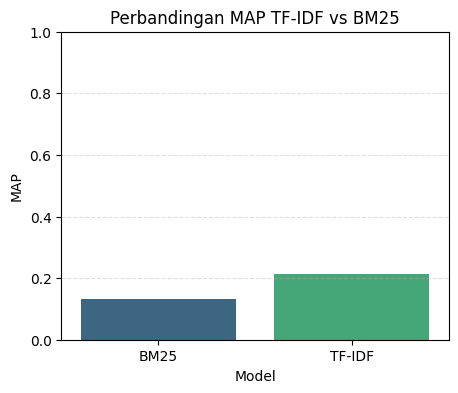

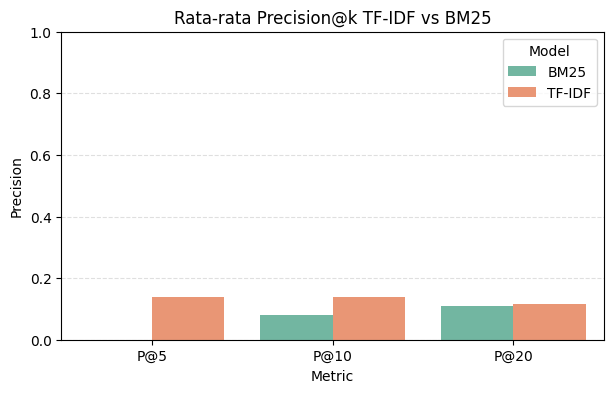

from matplotlib import pyplot as plt
avg_metrics['P@5'].plot(kind='hist', bins=20, title='P@5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics['P@10'].plot(kind='hist', bins=20, title='P@10')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics['P@20'].plot(kind='hist', bins=20, title='P@20')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics['AP'].plot(kind='hist', bins=20, title='AP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
avg_metrics.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics.plot(kind='scatter', x='P@5', y='P@10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics.plot(kind='scatter', x='P@10', y='P@20', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics.plot(kind='scatter', x='P@20', y='AP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics.plot(kind='scatter', x='AP', y='MAP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['P@5']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'P@5'}, axis=1)
              .sort_values('P@5', ascending=True))
  xs = counted['P@5']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = avg_metrics.sort_values('P@5', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('P@5')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['P@10']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'P@10'}, axis=1)
              .sort_values('P@10', ascending=True))
  xs = counted['P@10']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = avg_metrics.sort_values('P@10', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('P@10')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['P@20']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'P@20'}, axis=1)
              .sort_values('P@20', ascending=True))
  xs = counted['P@20']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = avg_metrics.sort_values('P@20', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('P@20')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['AP']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'AP'}, axis=1)
              .sort_values('AP', ascending=True))
  xs = counted['AP']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = avg_metrics.sort_values('AP', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('AP')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
avg_metrics['P@5'].plot(kind='line', figsize=(8, 4), title='P@5')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics['P@10'].plot(kind='line', figsize=(8, 4), title='P@10')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics['P@20'].plot(kind='line', figsize=(8, 4), title='P@20')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
avg_metrics['AP'].plot(kind='line', figsize=(8, 4), title='AP')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='P@5', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='P@10', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='P@20', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='AP', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [9]:
# ==============================
# 8. Ringkasan & diagram
# ==============================

def results_to_df(results, model_name):
    rows = []
    for qid, m in results.items():
        row = {"Model": model_name, "Query": qid}
        row.update(m)
        rows.append(row)
    return pd.DataFrame(rows)

df_tfidf = results_to_df(tfidf_results, "TF-IDF")
df_bm25 = results_to_df(bm25_results, "BM25")
summary_df = pd.concat([df_tfidf, df_bm25], ignore_index=True)

print("\nTabel hasil evaluasi per query:")
display(summary_df)

# Simpan tabel untuk laporan
summary_df.to_csv("IR_Evaluation_Results.csv", index=False)
print("Disimpan sebagai: IR_Evaluation_Results.csv")

# Hitung rata-rata P@k tiap model
avg_metrics = summary_df.groupby("Model")[["P@5", "P@10", "P@20", "AP"]].mean().reset_index()
avg_metrics["MAP"] = [tfidf_MAP if m == "TF-IDF" else bm25_MAP for m in avg_metrics["Model"]]
print("\nRata-rata metrik per model:")
display(avg_metrics)

# --- Diagram 1: MAP TF-IDF vs BM25 ---
plt.figure(figsize=(5,4))
sns.barplot(data=avg_metrics, x="Model", y="MAP", palette="viridis")
plt.title("Perbandingan MAP TF-IDF vs BM25")
plt.ylabel("MAP")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

# --- Diagram 2: Rata-rata Precision@k TF-IDF vs BM25 ---
avg_p = avg_metrics.melt(id_vars="Model", value_vars=["P@5", "P@10", "P@20"],
                         var_name="Metric", value_name="Score")

plt.figure(figsize=(7,4))
sns.barplot(data=avg_p, x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("Rata-rata Precision@k TF-IDF vs BM25")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Model")
plt.show()
